<a href="https://colab.research.google.com/github/Franklingo13/PVDefectDetect/blob/main/RNA/Entrenamiento_grietasGColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook para entrenamiento de redes neuronales convolucionales para clasificación de defectos en imágenes de celdas fotovoltaicas.
Pensado para correr en Google Colab.

In [1]:
# Conexión con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# SPDX-License-Identifier: Apache-2.0
#
# Copyright (C) 2021 Supervisely
#
# This file is part of the Supervisely project and has been taken
# from the Supervisely repository (https://github.com/supervisely/supervisely/blob/master/plugins/nn/unet_v2/src/unet.py).
# It is being redistributed under the Apache License 2.0.
#
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import torch
from torch import nn
from torchvision.models.vgg import vgg16_bn


class ConvBNAct(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, inputs):
        return self.seq(inputs)


class Block(nn.Module):
    def __init__(self, src_channels, dst_channels):
        super().__init__()
        self.seq1 = ConvBNAct(src_channels, dst_channels)
        self.seq2 = ConvBNAct(dst_channels, dst_channels)
        self.seq3 = ConvBNAct(dst_channels, dst_channels)

    def forward(self, x):
        result = self.seq1(x)
        result = self.seq2(result)
        result = self.seq3(result)
        return result


class UNetUp(nn.Module):
    def __init__(self, down_channels,  right_channels):
        super().__init__()
        self.bottom_up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(down_channels, right_channels, kernel_size=1, stride=1)

    def forward(self, left, bottom):
        from_bottom = self.bottom_up(bottom)
        from_bottom = self.conv(from_bottom)
        result = torch.cat([left, from_bottom], 1)
        return result


class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), dilation=2, padding=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), dilation=2, padding=2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.conv2(self.relu(out))
        out = self.bn2(out)
        return torch.cat((x, self.relu2(out)), dim=1)


class UNet(nn.Module):

    def __init__(self, encoder_blocks,  encoder_channels, n_cls):
        self.encoder_channels = encoder_channels
        self.depth = len(self.encoder_channels)
        assert len(encoder_blocks) == self.depth
        super().__init__()

        self.encoder_blocks = nn.ModuleList(encoder_blocks)

        self.blocks = nn.ModuleList()
        # add bottleneck
        self.blocks.append(Block(
            self.encoder_channels[-1],
            self.encoder_channels[-1]
        ))

        self.ups = nn.ModuleList()
        for i in range(1, self.depth):
            bottom_channels = self.encoder_channels[self.depth - i]
            left_channels = self.encoder_channels[self.depth - i - 1]
            right_channels = left_channels
            self.ups.append(UNetUp(bottom_channels,  right_channels))
            self.blocks.append(Block(
                left_channels + right_channels,
                right_channels
            ))
        self.last_conv = nn.Conv2d(encoder_channels[0], n_cls, 1)
        # self.dropout = nn.Dropout2d(p=0.1)
        self.bottle = Bottleneck(512, 512)

    def forward(self, x):
        encoder_outputs = []
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            encoder_outputs.append(x)
        x = self.bottle(encoder_outputs[self.depth - 1])
        for i in range(self.depth):
            if i > 0:
                encoder_output = encoder_outputs[self.depth - i - 1]
                x = self.ups[i - 1](encoder_output, x)
                x = self.blocks[i](x)
        # x = self.dropout(x)
        x = self.last_conv(x)
        return x  # no softmax or log_softmax


def _get_encoder_blocks(model):
    # last modules (ReLUs) of VGG blocks
    layers_last_module_names = ['5', '12', '22', '32', '42']
    result = []
    cur_block = nn.Sequential()
    for name, child in model.named_children():
        if name == 'features':
            for name2, child2 in child.named_children():
                cur_block.add_module(name2, child2)
                if name2 in layers_last_module_names:
                    result.append(cur_block)
                    cur_block = nn.Sequential()
            break

    return result


def construct_unet(n_cls, pretrain=False):  # no weights inited
    model = vgg16_bn(weights='DEFAULT')
    encoder_blocks = _get_encoder_blocks(model)
    encoder_channels = [64, 128, 256, 512, 1024]  # vgg16 channels
    # prev_channels = encoder_channels[-1]

    return UNet(encoder_blocks, encoder_channels, n_cls)


In [3]:
# Importación de librerías
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn import DataParallel
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.io import read_image, ImageReadMode
from torchvision.datasets.vision import VisionDataset
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

import cv2 as cv
import numpy as np

import requests
import copy
#from unet_model import construct_unet
from pathlib import Path
from PIL import Image
from imutils.paths import list_images
import os
import warnings

In [4]:
# Importación de la librería de pv-vision
!pip install pv-vision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [5]:
# Importar el manejador de modelo: ModelHandler
from pv_vision.nn import ModelHandler

In [6]:
# Definición de una clase para el conjunto de datos solar,
# que hereda de la clase VisionDataset de PyTorch.
class SolarDataset(VisionDataset):
    """Un conjunto de datos que lee directamente las imágenes y las máscaras desde una carpeta."""

    # Se definió el método de inicialización para la clase.
    def __init__(self,
                 root,
                 image_folder,
                 mask_folder,
                 transforms,
                 mode = "train",
                 random_seed=42):
        # Se llamó al método de inicialización de la clase padre.
        super().__init__(root, transforms)
        # Se establecieron las rutas a las carpetas de imágenes y máscaras.
        self.image_path = Path(self.root) / image_folder
        self.mask_path = Path(self.root) / mask_folder

        # Se verificó que las carpetas de imágenes y máscaras existan.
        if not os.path.exists(self.image_path):
            raise OSError(f"{self.image_path} no encontrado.")

        if not os.path.exists(self.mask_path):
            raise OSError(f"{self.mask_path} no encontrado.")

        # Se obtuvieron las listas de imágenes y máscaras y se ordenaron.
        self.image_list = sorted(list(list_images(self.image_path)))
        self.mask_list = sorted(list(list_images(self.mask_path)))

        # Se convirtieron las listas de imágenes y máscaras a arrays de numpy.
        self.image_list = np.array(self.image_list)
        self.mask_list = np.array(self.mask_list)

        # Se estableció la semilla para la generación de números aleatorios y se mezclaron las imágenes y las máscaras.
        np.random.seed(random_seed)
        index = np.arange(len(self.image_list))
        np.random.shuffle(index)
        self.image_list = self.image_list[index]
        self.mask_list = self.mask_list[index]

    # Se definió el método para obtener la longitud del conjunto de datos.
    def __len__(self):
        return len(self.image_list)

    # Se definió un método para obtener el nombre de una imagen o máscara.
    def __getname__(self, index):
        image_name = os.path.splitext(os.path.split(self.image_list[index])[-1])[0]
        mask_name = os.path.splitext(os.path.split(self.mask_list[index])[-1])[0]

        if image_name == mask_name:
            return image_name
        else:
            return False

    # Se definió un método para obtener una imagen y su máscara correspondiente.
    def __getraw__(self, index):
        if not self.__getname__(index):
            raise ValueError("{}: La imagen no coincide con la máscara".format(os.path.split(self.image_list[index])[-1]))
        image = Image.open(self.image_list[index])
        mask = Image.open(self.mask_list[index]).convert('L')
        mask = np.array(mask)
        mask = Image.fromarray(mask)

        return image, mask

    # Se definió el método para obtener un elemento del conjunto de datos.
    def __getitem__(self, index):
        image, mask = self.__getraw__(index)
        image, mask = self.transforms(image, mask)

        return image, mask

In [7]:
# Definición de una clase para componer varias transformaciones.
class Compose:
    def __init__(self, transforms):
        """
        transforms: una lista de transformaciones
        """
        self.transforms = transforms

    # Se definió el método para aplicar las transformaciones a la imagen y la máscara.
    def __call__(self, image, target):
        """
        image: imagen de entrada
        target: máscara de entrada
        """
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# Se definió una clase para redimensionar la imagen y la máscara a un tamaño fijo.
class FixResize:
    # UNet requiere que el tamaño de entrada sea múltiplo de 16
    def __init__(self, size):
        self.size = size

    # Se definió el método para redimensionar la imagen y la máscara.
    def __call__(self, image, target):
        image = F.resize(image, (self.size, self.size), interpolation=transforms.InterpolationMode.BILINEAR)
        target = F.resize(target, (self.size, self.size), interpolation=transforms.InterpolationMode.NEAREST)
        return image, target

# Se definió una clase para transformar la imagen y la máscara a tensores.
class ToTensor:
    """Transforma la imagen a tensor. Escala la imagen a [0,1] float32.
    Transforma la máscara a tensor.
    """
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

# Se definió una clase para transformar la imagen a tensor manteniendo el tipo original.
class PILToTensor:
    """Transforma la imagen a tensor. Mantiene el tipo original."""
    def __call__(self, image, target):
        image = F.pil_to_tensor(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target

# Se definió una clase para normalizar la imagen.
class Normalize:
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        # Verifica si la imagen es en escala de grises (1 canal) y la convierte a RGB (3 canales) si es necesario
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)  # Repite el canal existente 3 veces
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target

In [8]:
# Ruta al directorio que contiene las imágenes y las máscaras.
# root = Path(
#     '/content/drive/MyDrive/Trabajo de titulación/PV_vision/Entrenamiento')

root = Path(
    '/content/drive/MyDrive/Entrenamiento')

# Se definen las transformaciones a aplicar a las imágenes y las etiquetas.
#transformers = Compose([transforms.RandomRotation(degrees=30), FixResize(256), ToTensor(), Normalize()])
transformers = Compose([FixResize(256), ToTensor(), Normalize()])
# Se crean los conjuntos de datos de entrenamiento, validación y prueba.
trainset = SolarDataset(root, image_folder="train/img",
        mask_folder="train/ann", transforms=transformers)

valset = SolarDataset(root, image_folder="val/img",
        mask_folder="val/ann", transforms=transformers)

testset = SolarDataset(root, image_folder="test/img",
        mask_folder="test/ann", transforms=transformers)

# Verificación de que la carpeta haya sido establecida correctamente
print(f"El conjunto de datos de entrenamiento contiene {len(trainset)} elementos.")

El conjunto de datos de entrenamiento contiene 1453 elementos.


In [ ]:
class Accuracy:
    """Calcular la precisión de un modelo"""
    def __init__(self):
        self.__name__ = "accuracy"
        self._base = [0, 0]

    def calc(self, outputs, targets, reduction='mean'):
        """ Calcular la precisión.
        Argumentos:
        -----------
        outputs: torch.Tensor
        La salida del modelo, forma (batch_size, num_classes, H, W)

        targets: torch.Tensor
        La etiqueta verdadera, forma (batch_size, H, W)

        reduction: str
        El método de reducción, 'mean' o 'sum'
        Si es 'mean', devuelve la precisión media del lote
        Si es 'sum', devuelve la suma de predicciones correctas del lote

        Retorna:
        --------
        accuracy: torch.Tensor
        """
        # Asegúrate de que las dimensiones de outputs y targets sean compatibles
        if outputs.dim() == 4 and targets.dim() == 3:
            _, preds = torch.max(outputs, 1)
            correct = torch.sum(preds == targets)

            if reduction == 'mean':
                return correct.float() / targets.numel()
            elif reduction == 'sum':
                return correct
            else:
                raise ValueError("reduction debe ser 'mean' o 'sum'")
        else:
            raise ValueError("Las dimensiones de outputs y targets no son compatibles")

    def accumulate(self, outputs, targets):
        """ Acumular la métrica a lo largo de varios lotes."""
        if outputs.dim() == 4 and targets.dim() == 3:
            _, preds = torch.max(outputs, 1)
            correct = torch.sum(preds == targets)
            self._base[0] += correct
            self._base[1] += targets.numel()
        else:
            raise ValueError("Las dimensiones de outputs y targets no son compatibles")

    def reset(self):
        self._base = [0, 0]

    def accumulated_score(self):
        """ Devolver la puntuación acumulada en una época."""
        if self._base[1] == 0:
            # advertencia de división por cero
            warnings.warn("El denominador es cero, devuelve 0", RuntimeWarning)
            return 0
        return self._base[0].float() / self._base[1]

    def __call__(self, outputs, targets, reduction='mean'):
        return self.calc(outputs, targets, reduction)

In [ ]:
## Definición de una clase para calcular el Índice de Jaccard, o Intersección sobre Unión (IoU)
class JaccardIndex:
    def __init__(self):
        # Se define el nombre de la métrica para referencia
        self.__name__ = 'jaccard_index'

    def __call__(self, preds, targets):
        """
        Calcula el Índice de Jaccard (IoU) entre las predicciones y los objetivos.
        
        Parámetros:
        preds: tensor de PyTorch con las predicciones del modelo.
        targets: tensor de PyTorch con los valores verdaderos (ground truth).
        
        Retorna:
        iou: El valor del Índice de Jaccard.
        """
        
        # Asegurarse de que las predicciones sean binarias (0 o 1)
        preds = (preds > 0.5).float()

        # Calcular la intersección y la unión
        intersection = torch.sum(preds * targets)
        union = torch.sum(preds + targets) - intersection
        
        # Calcular IoU evitando la división por cero
        iou = intersection / (union + 1e-8)
        
        return iou.item()


In [ ]:
# Se define una función para crear un modelo DeepLab preentrenado.
def DeepLab_pretrained(num_classes):
    # Se carga el modelo DeepLab con una arquitectura ResNet50 preentrenada.
    deeplab = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)

    # Se reemplaza el clasificador del modelo con un nuevo clasificador DeepLabHead.
    # El nuevo clasificador tiene 2048 características de entrada y 'num_classes' características de salida.
    deeplab.classifier = DeepLabHead(2048, num_classes)

    # Se devuelve el modelo modificado.
    return deeplab

In [9]:
# Crea una instancia del modelo U-Net con 5 canales de salida.
# Número de canales de salida = al número de clases
unet = construct_unet(5)
# Se "envuelve" el modelo en un objeto DataParallel.
# Esto permite que el modelo se ejecute en paralelo en múltiples GPUs, si están disponibles.
unet = DataParallel(unet)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 68.3MB/s]


In [10]:
# Se define el dispositivo en el que se ejecutará el modelo.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Se imprime el dispositivo utilizado.
print(f"Dispositivo utilizado: {device}")

# Se crea el modelo utilizando la función DeepLab_pretrained definida anteriormente.
# El modelo se envuelve en un objeto DataParallel para permitir el entrenamiento en múltiples GPUs si están disponibles.
#model = DataParallel(DeepLab_pretrained(5))

# Se define la función de pérdida a utilizar durante el entrenamiento.
# En este caso, se utiliza la pérdida de entropía cruzada.
criterion = CrossEntropyLoss()

# Se define el optimizador a utilizar durante el entrenamiento. En este caso, se utiliza Adam con una tasa de aprendizaje de 0.01.
#optimizer = Adam(model.parameters(), lr=0.01)
optimizer = Adam(unet.parameters(), lr=0.0005)

# Se define el programador de la tasa de aprendizaje a utilizar durante el entrenamiento.
# En este caso, se utiliza un programador de paso que disminuye la tasa de aprendizaje en un factor de 0.2 cada 5 épocas.
lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.05)

Dispositivo utilizado: cuda:0


In [11]:
# Cargar los pesos del modelo preentrenado

weight_path = '/content/drive/MyDrive/Entrenamiento/unetv25.pt'
unet.load_state_dict(torch.load(weight_path, map_location=device))

<All keys matched successfully>

In [12]:
# Se inicializa el manejador del modelo.
# La salida se almacena en la carpeta de salida.
modelhandler = ModelHandler(
    # Se pasa el modelo que se va a entrenar.
    #model=model,
    model = unet,
    # Se especifica el nombre de la carpeta de salida.
    #model_output='out_unet',
    # Se pasan los conjuntos de datos de entrenamiento, validación y prueba.
    train_dataset=trainset,
    val_dataset=valset,
    test_dataset=testset,
    # Se especifica el tamaño del lote para el entrenamiento y la validación.
    batch_size_train=32,
    batch_size_val=32,
    # Se pasa el programador de la tasa de aprendizaje.
    lr_scheduler=lr_scheduler,
    # Se especifica el número de épocas para el entrenamiento.
    num_epochs=42,
    # Se pasa la función de pérdida y el optimizador.
    criterion=criterion,
    optimizer=optimizer,
    # Se pasa el dispositivo en el que se ejecutará el entrenamiento.
    device=device,
    evaluate_metric= JaccardIndex,
    # Se especifica el directorio donde se guardarán los puntos de control del modelo.
    save_dir='/content/drive/MyDrive/Entrenamiento/checkpoints',
    # Se especifica el nombre del archivo de punto de control.
    save_name='unetv26.pt'
)

INFO:pv_vision.nn.modelhandler:ModelHandler initialized.


In [13]:
# Se inicializa el entrenamiento del modelo.
modelhandler.train_model()

Epoch 1 / 42
----------


100%|██████████| 46/46 [19:46<00:00, 25.80s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 1
100%|██████████| 3/3 [02:18<00:00, 46.30s/it]
INFO:pv_vision.nn.modelhandler:Val epoch: 1 	Average loss: 0.0774


Loss: 0.0411 (train) | 0.0774 (val)
Epoch 2 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.18s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 2
100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 2 	Average loss: 0.0774


Loss: 0.0409 (train) | 0.0774 (val)
Epoch 3 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 3
100%|██████████| 3/3 [00:01<00:00,  1.50it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 3 	Average loss: 0.0774


Loss: 0.0403 (train) | 0.0774 (val)
Epoch 4 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 4
100%|██████████| 3/3 [00:01<00:00,  1.50it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 4 	Average loss: 0.0765


Loss: 0.0399 (train) | 0.0765 (val)
Epoch 5 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 5
100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 5 	Average loss: 0.0750


Loss: 0.0396 (train) | 0.0750 (val)
Epoch 6 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 6
100%|██████████| 3/3 [00:02<00:00,  1.50it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 6 	Average loss: 0.0745


Loss: 0.0396 (train) | 0.0745 (val)
Epoch 7 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 7
100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 7 	Average loss: 0.0761


Loss: 0.0393 (train) | 0.0761 (val)
Epoch 8 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 8
100%|██████████| 3/3 [00:02<00:00,  1.50it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 8 	Average loss: 0.0725


Loss: 0.0380 (train) | 0.0725 (val)
Epoch 9 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 9
100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 9 	Average loss: 0.0720


Loss: 0.0374 (train) | 0.0720 (val)
Epoch 10 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 10
100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 10 	Average loss: 0.0719


Loss: 0.0372 (train) | 0.0719 (val)
Epoch 11 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 11
100%|██████████| 3/3 [00:02<00:00,  1.47it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 11 	Average loss: 0.0717


Loss: 0.0371 (train) | 0.0717 (val)
Epoch 12 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 12
100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 12 	Average loss: 0.0715


Loss: 0.0372 (train) | 0.0715 (val)
Epoch 13 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 13
100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 13 	Average loss: 0.0716


Loss: 0.0371 (train) | 0.0716 (val)
Epoch 14 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 14
100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 14 	Average loss: 0.0713


Loss: 0.0371 (train) | 0.0713 (val)
Epoch 15 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 15
100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 15 	Average loss: 0.0714


Loss: 0.0368 (train) | 0.0714 (val)
Epoch 16 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 16
100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 16 	Average loss: 0.0713


Loss: 0.0369 (train) | 0.0713 (val)
Epoch 17 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 17
100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 17 	Average loss: 0.0713


Loss: 0.0369 (train) | 0.0713 (val)
Epoch 18 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 18
100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 18 	Average loss: 0.0713


Loss: 0.0369 (train) | 0.0713 (val)
Epoch 19 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 19
100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 19 	Average loss: 0.0713


Loss: 0.0368 (train) | 0.0713 (val)
Epoch 20 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 20
100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 20 	Average loss: 0.0713


Loss: 0.0369 (train) | 0.0713 (val)
Epoch 21 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 21
100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 21 	Average loss: 0.0713


Loss: 0.0369 (train) | 0.0713 (val)
Epoch 22 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 22
100%|██████████| 3/3 [00:01<00:00,  1.50it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 22 	Average loss: 0.0713


Loss: 0.0369 (train) | 0.0713 (val)
Epoch 23 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 23
100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 23 	Average loss: 0.0713


Loss: 0.0369 (train) | 0.0713 (val)
Epoch 24 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 24
100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 24 	Average loss: 0.0712


Loss: 0.0370 (train) | 0.0712 (val)
Epoch 25 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 25
100%|██████████| 3/3 [00:02<00:00,  1.50it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 25 	Average loss: 0.0711


Loss: 0.0367 (train) | 0.0711 (val)
Epoch 26 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 26
100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 26 	Average loss: 0.0713


Loss: 0.0366 (train) | 0.0713 (val)
Epoch 27 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 27
100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 27 	Average loss: 0.0713


Loss: 0.0369 (train) | 0.0713 (val)
Epoch 28 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 28
100%|██████████| 3/3 [00:02<00:00,  1.47it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 28 	Average loss: 0.0712


Loss: 0.0368 (train) | 0.0712 (val)
Epoch 29 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 29
100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 29 	Average loss: 0.0713


Loss: 0.0367 (train) | 0.0713 (val)
Epoch 30 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 30
100%|██████████| 3/3 [00:01<00:00,  1.52it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 30 	Average loss: 0.0712


Loss: 0.0368 (train) | 0.0712 (val)
Epoch 31 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 31
100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 31 	Average loss: 0.0712


Loss: 0.0369 (train) | 0.0712 (val)
Epoch 32 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 32
100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 32 	Average loss: 0.0713


Loss: 0.0368 (train) | 0.0713 (val)
Epoch 33 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 33
100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 33 	Average loss: 0.0712


Loss: 0.0371 (train) | 0.0712 (val)
Epoch 34 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 34
100%|██████████| 3/3 [00:01<00:00,  1.50it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 34 	Average loss: 0.0712


Loss: 0.0369 (train) | 0.0712 (val)
Epoch 35 / 42
----------


100%|██████████| 46/46 [00:55<00:00,  1.20s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 35
100%|██████████| 3/3 [00:02<00:00,  1.47it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 35 	Average loss: 0.0712


Loss: 0.0367 (train) | 0.0712 (val)
Epoch 36 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 36
100%|██████████| 3/3 [00:01<00:00,  1.50it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 36 	Average loss: 0.0714


Loss: 0.0369 (train) | 0.0714 (val)
Epoch 37 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 37
100%|██████████| 3/3 [00:02<00:00,  1.49it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 37 	Average loss: 0.0712


Loss: 0.0367 (train) | 0.0712 (val)
Epoch 38 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 38
100%|██████████| 3/3 [00:02<00:00,  1.50it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 38 	Average loss: 0.0712


Loss: 0.0368 (train) | 0.0712 (val)
Epoch 39 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 39
100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 39 	Average loss: 0.0714


Loss: 0.0367 (train) | 0.0714 (val)
Epoch 40 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 40
100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 40 	Average loss: 0.0714


Loss: 0.0367 (train) | 0.0714 (val)
Epoch 41 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 41
100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 41 	Average loss: 0.0712


Loss: 0.0369 (train) | 0.0712 (val)
Epoch 42 / 42
----------


100%|██████████| 46/46 [00:54<00:00,  1.19s/it]
INFO:pv_vision.nn.modelhandler:Saved model at epoch 42
100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
INFO:pv_vision.nn.modelhandler:Val epoch: 42 	Average loss: 0.0712


Loss: 0.0369 (train) | 0.0712 (val)


{'train': {'loss': [0.04107159146166061,
   0.040859315873823,
   0.04025951409885494,
   0.03989655943427181,
   0.039621457429339944,
   0.03959092945475785,
   0.03931974901138957,
   0.03800194517947113,
   0.03739738311292956,
   0.03720764891184861,
   0.03710320603207564,
   0.037150331915799126,
   0.03706842378622814,
   0.037050235339652564,
   0.03682957562064804,
   0.03688746920215698,
   0.03688859683060884,
   0.03685429701241886,
   0.03678775251332186,
   0.036862622056840946,
   0.03692705507011391,
   0.03688078703639512,
   0.03689244886923066,
   0.03704320309402938,
   0.03668698773213649,
   0.03664121128803315,
   0.036884686271855524,
   0.036829111083613864,
   0.03667664581221379,
   0.03678372594113195,
   0.036893472542085075,
   0.036786738165230565,
   0.03707519184903121,
   0.036875944360270224,
   0.03672840796457187,
   0.0368559251745159,
   0.03665444190522268,
   0.036813475896655,
   0.036734231634236,
   0.036727120542189864,
   0.036868809753771

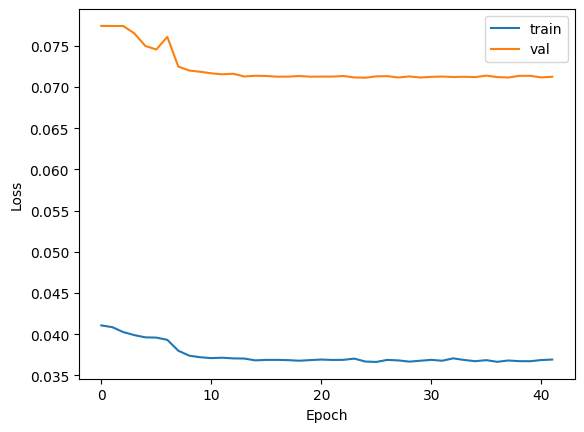

In [14]:
# Se visualiza el proceso de entrenamiento.
# Esta función traza la pérdida del modelo durante el entrenamiento.
modelhandler.plot_loss()

In [15]:
# Se busca la pérdida mínima en la validación, que corresponde al mejor modelo.
# 'np.argmin' devuelve el índice de la pérdida mínima en el conjunto de validación.
# Se suma 1 porque los índices en Python comienzan en 0, pero las épocas comienzan en 1.
np.argmin(modelhandler.running_record['val']['loss'])+1

25

In [16]:
# Se carga el mejor modelo entrenado y se verifica su rendimiento en el conjunto de prueba.
# Se emplea `load_model` para cargar el modelo entrenado. Este método toma el nombre del archivo de punto de control.
modelhandler.load_model('/content/drive/MyDrive/Entrenamiento/checkpoints/epoch_25/unetv25.pt')

INFO:pv_vision.nn.modelhandler:Loaded model from /content/drive/MyDrive/Entrenamiento/checkpoints/epoch_25/unetv25.pt


El siguiente código prueba el modelo en el conjunto de prueba y almacena la salida en 'testset_output'. También se hace un comentario sobre la puntuación de la prueba y la puntuación de la validación.

In [17]:
# Se evalúa el modelo en el conjunto de prueba. `test_model` es una función de ModelHandler
# que evalúa el modelo en el conjunto de prueba y almacena la salida en la caché.
_ = modelhandler.test_model(cache_output='testset_outputv25')

# La salida del modelo se almacena en self.cache['testset_output']

Testing mode
----------


100%|██████████| 12/12 [09:32<00:00, 47.69s/it]
INFO:pv_vision.nn.modelhandler:Test set: Average loss: 0.1188


Test set: Average loss: 0.1188
